## Case 2 : Pre-trained word_embed + Dense <br> <small>when available data is significantly little</small>

### Import data

In [1]:
from keras.datasets import imdb

max_features = 10000

(data, labels), (x_test, y_test) = imdb.load_data(num_words=max_features)

Using TensorFlow backend.


### Pad X into maxlen

In [2]:
from keras import preprocessing

maxlen = 100

data = preprocessing.sequence.pad_sequences(data, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

### Train-validation split

In [3]:
import numpy as np

training_samples = 200
validation_samples = 10000

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples:training_samples+validation_samples]
y_val = labels[training_samples:training_samples+validation_samples]

### Create embedding_matrix

In [4]:
import os
import numpy as np

embedding_dim=100

glove_dir = './glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_matrix = np.zeros((max_features, embedding_dim))
word_index = imdb.get_word_index()
for word, i in word_index.items():
    if i < max_features:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

### The model

In [9]:
from keras import layers
from keras import models
from keras import optimizers
from keras import losses
from keras import metrics

def run_model(x_train, y_train, x_val, y_val, use_pretrain=False, embedding_matrix=None):
    model = models.Sequential()
    model.add(layers.Embedding(input_dim=max_features, 
                               output_dim=embedding_dim, 
                               input_length=maxlen))
    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    if use_pretrain:
        if embedding_matrix is None:
            raise Exception('embedding_matrix not provided')
        model.layers[0].set_weights([embedding_matrix])
        model.layers[0].trainable = False

    model.compile(optimizer=optimizers.RMSprop(lr=1e-3),
                  loss=losses.binary_crossentropy,
                  metrics=[metrics.binary_accuracy])
    history = model.fit(x_train, 
                        y_train,
                        epochs=10,
                        batch_size=32,
                        validation_data=(x_val, y_val),
                        verbose=0)
    return history

### Training

In [10]:
history = run_model(x_train, y_train, x_val, y_val, True, embedding_matrix)

### Training the same model without pretrained word embeddings

In [11]:
history2 = run_model(x_train, y_train, x_val, y_val)

### Compare with / without pre-train word embed

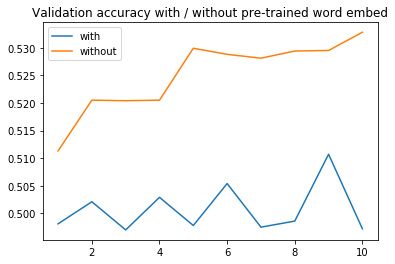

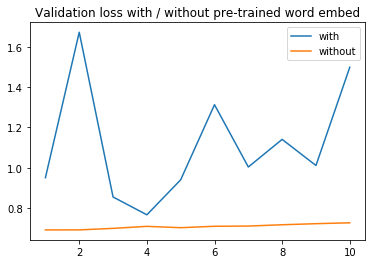

In [15]:
import matplotlib.pyplot as plt

val_acc1 = history.history['val_binary_accuracy']
val_acc2 = history2.history['val_binary_accuracy']
val_loss1 = history.history['val_loss']
val_loss2 = history2.history['val_loss']


epochs = range(1, len(val_acc1) + 1)

plt.plot(epochs, val_acc1, label='with')
plt.plot(epochs, val_acc2, label='without')
plt.title('Validation accuracy with / without pre-trained word embed')
plt.legend()

plt.figure()

plt.plot(epochs, val_loss1, label='with')
plt.plot(epochs, val_loss2, label='without')
plt.title('Validation loss with / without pre-trained word embed')
plt.legend()

plt.show()